In [2]:
import vtk
from vtk.util import numpy_support
import nibabel as nib
import numpy as np
from tqdm import tqdm
import high_res_angles_extraction
import polydata_to_imagedata
import open3d as o3d

ModuleNotFoundError: No module named 'high_res_angles_extraction'

In [89]:
def convert_stl_to_vtk(stl_file_path, outpath):

    # Read the STL file
    reader = vtk.vtkSTLReader()
    reader.SetFileName(stl_file_path)
    reader.Update()

    # Get the polydata from the reader
    polydata = reader.GetOutput()

    # Write the polydata to a VTK file
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(outpath)
    writer.SetInputData(polydata)
    writer.Write()

def convert_vtk_to_ply(vtk_file, ply_file):
    # Read the VTK file
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(vtk_file)
    reader.Update()

    # Get the VTK polydata
    polydata = reader.GetOutput()

    # Convert VTK polydata to Trimesh mesh
    vertices = vtk.util.numpy_support.vtk_to_numpy(polydata.GetPoints().GetData())
    faces = vtk.util.numpy_support.vtk_to_numpy(polydata.GetPolys().GetData()).reshape(-1, 4)[:, 1:]
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

    # Save the mesh as a PLY file
    mesh.export(ply_file, file_type='ply')

def convert_obj_to_vtk(obj_file_path, outpath):

    # Read the OBJ file
    reader = vtk.vtkOBJReader()
    reader.SetFileName(obj_file_path)
    reader.Update()

    # Get the polydata from the reader
    polydata = reader.GetOutput()

    # Write the polydata to a VTK file
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(outpath)
    writer.SetInputData(polydata)
    writer.Write()

def convert_ply_to_vtk(ply_file_path, outpath):

    # Read the OBJ file
    reader = vtk.vtkOBJReader()
    reader.SetFileName(ply_file_path)
    reader.Update()

    # Get the polydata from the reader
    polydata = reader.GetOutput()

    # Write the polydata to a VTK file
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(outpath)
    writer.SetInputData(polydata)
    writer.Write()

def convert_vtk_to_nii(vtk_file_path, nifti_file_path):

    # Read the VTK file
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(vtk_file_path)
    reader.Update()


    # Get the polydata from the reader
    polydata = reader.GetOutput()

    # Extract the vertices and triangles from the polydata
    points = polydata.GetPoints().GetData()
    triangles = polydata.GetPolys().GetData()

    # Convert points and triangles to numpy arrays
    vertices = np.array([points.GetTuple3(i) for i in range(points.GetNumberOfTuples())])
    faces = np.array([triangles.GetTuple3(i)[1:] for i in range(0, triangles.GetNumberOfTuples(), 4)])

    # Create an empty NIfTI image
    image = np.zeros((128, 128, 128), dtype=np.uint8)  # Adjust dimensions as needed

    # Set the voxel values within the mesh to 1
    for face in tqdm(faces):

        x, y, z = vertices[face]
        x, y, z = np.round(x).astype(int), np.round(y).astype(int), np.round(z).astype(int)
        image[x, y, z] = 1

    print('hi')

    # Create a NIfTI image object
    nifti_img = nib.Nifti1Image(image, affine=np.eye(4))  # Provide the appropriate affine transformation matrix

    # Save the NIfTI image to a file
    nib.save(nifti_img, nifti_file_path)

    print("Conversion complete.")

def scale_up_vertices_obj(input, output):
    # Create the PLY reader
    reader = vtk.vtkOBJReader()
    reader.SetFileName(input)

    # Read the PLY file
    reader.Update()

    # Get the output polydata
    polydata = reader.GetOutput()

    # Access the vertices in the polydata
    points = polydata.GetPoints()

    # Define the scaling factor for expansion
    scaling_factor = 40.0

    # Expand the vertices by scaling their coordinates
    for i in tqdm(range(points.GetNumberOfPoints())):
        point = points.GetPoint(i)
        expanded_point = [coord * scaling_factor for coord in point]
        points.SetPoint(i, expanded_point)

    # Optionally, you can write the modified polydata to a new PLY file
    writer = vtk.vtkOBJWriter()
    writer.SetFileName(output)
    writer.SetInputData(polydata)
    writer.Write()

def close_vtk_surface(open_surface, closed_surface_file):
    # Load the open surface mesh
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(open_surface)
    reader.Update()

    # Compute surface normals
    normals = vtk.vtkPolyDataNormals()
    normals.SetInputData(reader.GetOutput())
    normals.ComputePointNormalsOn()
    normals.ComputeCellNormalsOff()
    normals.AutoOrientNormalsOn()
    normals.Update()

    # Clean the surface
    clean = vtk.vtkCleanPolyData()
    clean.SetInputData(normals.GetOutput())
    clean.Update()

    # Close the surface by adding a cap
    cap = vtk.vtkFillHolesFilter()
    cap.SetInputData(clean.GetOutput())
    cap.SetHoleSize(100000)  # Adjust the hole size threshold as needed
    cap.Update()

    # Get the closed surface
    closed_surface = cap.GetOutput()

    # Save the closed surface to a VTK file
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(closed_surface_file)
    writer.SetInputData(closed_surface)
    writer.Write()

##Convert stl to vtk
#stl_path = "obj2test.stl"
#vtkpath = "test.vtk"
#convert_stl_to_vtk(stl_path, vtkpath)
#nii_path = "test.nii"
#convert_vtk_to_nii(vtkpath, nii_path)

# ply_path = "COLMAP/lunchbox2.ply"
# outpath = "lunchbox2.vtk"
# convert_ply_to_vtk(ply_path, outpath)

obj_path = "COLMAP/boxtest.obj"
outpath = "COLMAP/boxtestscaled.obj"
#scale_up_vertices_obj(obj_path, outpath)
#convert_obj_to_vtk(obj_path, outpath)

In [11]:
stl="COLMAP/hiptest.stl"
vtkp = "COLMAP/hiptest.vtk"
convert_stl_to_vtk(stl, vtkp)

In [12]:
obj_path = "/home-nfs2/local/VANDERBILT/kimm58/Projects/Pancreas/COLMAP/video/lunchbox/base.obj"
outpath = "/home-nfs2/local/VANDERBILT/kimm58/Projects/Pancreas/COLMAP/video/lunchbox/basescaled.obj"
scale_up_vertices_obj(obj_path, outpath)

100%|██████████| 582272/582272 [00:00<00:00, 1324093.61it/s]


In [7]:
    # Read the OBJ file
    reader = vtk.vtkPLYReader()
    reader.SetFileName("/home-nfs2/local/VANDERBILT/kimm58/Projects/Pancreas/COLMAP/lunchbox2.ply")
    reader.Update()

    # Get the polydata from the reader
    polydata = reader.GetOutput()

In [8]:
mesh = polydata_to_imagedata.read_mesh_file("/home-nfs2/local/VANDERBILT/kimm58/Projects/Pancreas/COLMAP/lunchbox2.ply")
imgdata = polydata_to_imagedata.polydata_to_imagedata(mesh)
polydata_to_imagedata.save(imgdata, "/home-nfs2/local/VANDERBILT/kimm58/Projects/Pancreas/COLMAP/lunchbox2.vti")

# # # load 3D volume
# # volume_reader = sitk.ImageSeriesReader()
# # dicom_names = volume_reader.GetGDCMSeriesFileNames(multi_slice_volume_path)
# # volume_reader.SetFileNames(dicom_names)
# # image = volume_reader.Execute()

# # load vtk points
# reader = vtk.vtkPolyDataReader()
# reader.SetFileName("~/Projects/Pancreas/test.vtk")
# reader.Update()
# vtkdata = reader.GetOutput()
# vtk_points = numpy_support.vtk_to_numpy(vtkdata.GetPoints().GetData()) 

# # convert vtk points to image coordinates
# image_points = np.zeros((vtk_points.shape))

# # for i, coord in enumerate(vtk_points):
# #    coord = (float(coord[0]), float(coord[1]), float(coord[2]))
# #    image_points[i] = np.array(image.TransformPhysicalPointToIndex(coord)).astype(int)

In [3]:
import trimesh

mesh = trimesh.load_mesh("/home-nfs2/local/VANDERBILT/kimm58/Projects/Pancreas/COLMAP/lunchbox2.ply")


In [11]:
def remove_colors_from_mesh(mesh, output):
    face_colors = mesh.visual.face_colors[:, :3]
    color_threshold = [100,100,100]
    faces_to_keep = np.any(face_colors <= color_threshold, axis=1)

    selectedv = mesh.vertices
    selectedf = mesh.faces[faces_to_keep]

    # Create a new mesh with the selected vertices and faces
    new_mesh = trimesh.Trimesh(vertices=selectedv, faces=selectedf)

    # Remove isolated vertices
    new_mesh.remove_unreferenced_vertices()

    new_mesh.export(output, file_type='ply')

def convert_binary_to_int_ply(input, output):
    
    mesh = trimesh.load_mesh(input)
    
    vertices = mesh.vertices
    vertex_colors= mesh.visual.vertex_colors

    vertices = vertices.astype(np.float32)
    vertex_colors = vertex_colors.astype(np.uint8)

    updated_mesh = trimesh.Trimesh(vertices=vertices, vertex_colors=vertex_colors, faces=mesh.faces)

    updated_mesh.export(output, file_type='ply')

remove_colors_from_mesh(mesh, '/home-nfs2/local/VANDERBILT/kimm58/Projects/Pancreas/COLMAP/decimated.ply')

In [5]:
#convert_binary_to_int_ply('/home-local/kimm58/SPIE2023/data/H1Capture/ImageToStl.com_ceramic_hip.ply', '/home-local/kimm58/SPIE2023/data/H1Capture/ceramic_hip_int.ply')
mesh2 = trimesh.load_mesh('/home-local/kimm58/SPIE2023/data/H1Capture/ceramic_hip_int.ply')
#remove_colors_from_mesh(mesh2, '/home-local/kimm58/SPIE2023/data/H1Capture/ceramic_hip_removed.ply')

In [16]:
print(np.unique(mesh2.visual.vertex_colors, axis=0))

[[220 220 220 255]]


In [10]:
from PIL import Image
import os
import open3d as o3d

def get_texture_path(mtl_path):
    # Load the MTL file
    #mtl_path = 'path/to/your/file.mtl'
    with open(mtl_path, 'r') as mtl_file:
        lines = mtl_file.readlines()

    # Find the texture image path
    texture_path = None
    for line in lines:
        if line.startswith('map_Kd'):
            texture_path = line.split()[1]
            break
    parent = os.path.dirname(mtl_path)

    return "{}/{}".format(parent, texture_path)

def convert_obj_to_ply_color(path, mtl):

    mesh = trimesh.load(path, force="mesh")
    texture_path = get_texture_path(mtl)

    texture_image = Image.open(texture_path)
    texture_image = texture_image.convert("RGB")
    texture_pixels = np.array(texture_image)

    # Map texture to vertex colors based on UV coordinates
    uvs = mesh.visual.uv
    face_uvs = uvs[mesh.faces]
    vertex_colors = np.zeros_like(mesh.vertices)

    for face, face_uv in zip(mesh.faces, face_uvs):
        uv1, uv2, uv3 = face_uv
        texcoord1, texcoord2, texcoord3 = uv1 * np.array(texture_image.size), uv2 * np.array(texture_image.size), uv3 * np.array(texture_image.size)
        texcoord1, texcoord2, texcoord3 = texcoord1.astype(int), texcoord2.astype(int), texcoord3.astype(int)
        color1, color2, color3 = texture_pixels[texcoord1[1], texcoord1[0]], texture_pixels[texcoord2[1], texcoord2[0]], texture_pixels[texcoord3[1], texcoord3[0]]
        vertex_colors[face[0]] = color1
        vertex_colors[face[1]] = color2
        vertex_colors[face[2]] = color3

    mesh.visual.vertex_colors = vertex_colors

    # Export modified mesh with vertex colors as PLY file
    parent = os.path.dirname(path)
    ply_path = '{}/modified.ply'.format(parent)
    mesh.export(ply_path, file_type='ply')

def convert_ply_binary_to_ascii(path):

    # Load the binary PLY file
    mesh = o3d.io.read_triangle_mesh(path)

    # Convert the mesh to an ASCII PLY file
    ascii_ply_path = '{}/converted_ascii.ply'.format(os.path.dirname(path))
    o3d.io.write_triangle_mesh(ascii_ply_path, mesh, write_ascii=True)

convert_obj_to_ply_color('/home-local/kimm58/SPIE2023/data/H1Capture/ceramic_hip.obj', '/home-local/kimm58/SPIE2023/data/H1Capture/ceramic_hip.mtl')
convert_ply_binary_to_ascii('/home-local/kimm58/SPIE2023/data/H1Capture/modified.ply')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [17]:
#convert_obj_to_vtk('/home-local/kimm58/SPIE2023/data/H1Capture/hip_on_bottle.obj', '/home-local/kimm58/SPIE2023/data/H1Capture/hip_on_bottle.vtk')
close_vtk_surface('/home-local/kimm58/SPIE2023/data/H1Capture/hip_on_bottle.vtk', '/home-local/kimm58/SPIE2023/data/H1Capture/hip_on_bottle_closed.vtk')

### Closing the open surface

In [15]:
import trimesh
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.optimize import minimize
import shapely
import rtree
from plyfile import PlyData
#use PCA to find the principal axes of the mesh

def plot_mesh_and_pricipal_axes_matplotlib(vertices, centroid, eigenvalues, principal_axes):

    # Plot the mesh
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], cmap='viridis')

    # Plot the principal axes
    origin = centroid
    axes_lengths = eigenvalues  # You can scale the axes by the eigenvalues if desired

    # Plot the first principal axis
    axis1_start = origin
    axis1_end = origin + axes_lengths[0] * principal_axes[0]
    ax.plot([axis1_start[0], axis1_end[0]], [axis1_start[1], axis1_end[1]], [axis1_start[2], axis1_end[2]], color='r')

    # Plot the second principal axis
    axis2_start = origin
    axis2_end = origin + axes_lengths[1] * principal_axes[1]
    ax.plot([axis2_start[0], axis2_end[0]], [axis2_start[1], axis2_end[1]], [axis2_start[2], axis2_end[2]], color='g')

    # Plot the third principal axis
    axis3_start = origin
    axis3_end = origin + axes_lengths[2] * principal_axes[2]
    ax.plot([axis3_start[0], axis3_end[0]], [axis3_start[1], axis3_end[1]], [axis3_start[2], axis3_end[2]], color='b')

    # Set plot limits and labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Show the plot
    plt.show()

def plot_mesh_and_pricipal_axes(vertices, centroid, eigenvalues, principal_axes):
    # Plot the mesh
    fig = go.Figure(data=[go.Mesh3d(x=vertices[:, 0], y=vertices[:, 1], z=vertices[:, 2], color='lightblue')])

    # Plot the principal axes
    origin = centroid
    axes_lengths = eigenvalues  # You can scale the axes by the eigenvalues if desired

    # Compute the maximum distance between any two points in the mesh
    max_distance = np.max(np.linalg.norm(vertices - centroid, axis=1))

    # Scale factor for the axes
    scale_factor = max_distance / np.max(eigenvalues)

    # Plot the first principal axis
    axis1_start = origin
    axis1_end = origin + principal_axes[0] * max_distance
    fig.add_trace(go.Scatter3d(x=[axis1_start[0], axis1_end[0]], y=[axis1_start[1], axis1_end[1]], z=[axis1_start[2], axis1_end[2]], mode='lines', line=dict(color='red')))

    # Plot the second principal axis
    axis2_start = origin
    axis2_end = origin + principal_axes[1] * max_distance
    fig.add_trace(go.Scatter3d(x=[axis2_start[0], axis2_end[0]], y=[axis2_start[1], axis2_end[1]], z=[axis2_start[2], axis2_end[2]], mode='lines', line=dict(color='green')))

    # Plot the third principal axis
    axis3_start = origin
    axis3_end = origin +  principal_axes[2] * max_distance
    fig.add_trace(go.Scatter3d(x=[axis3_start[0], axis3_end[0]], y=[axis3_start[1], axis3_end[1]], z=[axis3_start[2], axis3_end[2]], mode='lines', line=dict(color='blue')))

    # Set plot layout
    fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))

    # Show the plot
    fig.show()

def plot_mesh_and_pricipal_axes_and_plane(vertices, centroid, eigenvalues, principal_axes, best_position):
    # Plot the mesh
    fig = go.Figure(data=[go.Mesh3d(x=vertices[:, 0], y=vertices[:, 1], z=vertices[:, 2], color='lightblue')])

    # Plot the principal axes
    origin = centroid
    axes_lengths = eigenvalues  # You can scale the axes by the eigenvalues if desired

    # Compute the maximum distance between any two points in the mesh
    max_distance = np.max(np.linalg.norm(vertices - centroid, axis=1))

    # Scale factor for the axes
    scale_factor = max_distance / np.max(eigenvalues)

    # Plot the first principal axis
    axis1_start = origin
    axis1_end = origin + principal_axes[0] * max_distance
    fig.add_trace(go.Scatter3d(x=[axis1_start[0], axis1_end[0]], y=[axis1_start[1], axis1_end[1]], z=[axis1_start[2], axis1_end[2]], mode='lines', line=dict(color='red')))

    # Plot the second principal axis
    axis2_start = origin
    axis2_end = origin + principal_axes[1] * max_distance
    fig.add_trace(go.Scatter3d(x=[axis2_start[0], axis2_end[0]], y=[axis2_start[1], axis2_end[1]], z=[axis2_start[2], axis2_end[2]], mode='lines', line=dict(color='green')))

    # Plot the third principal axis
    axis3_start = origin
    axis3_end = origin +  principal_axes[2] * max_distance
    fig.add_trace(go.Scatter3d(x=[axis3_start[0], axis3_end[0]], y=[axis3_start[1], axis3_end[1]], z=[axis3_start[2], axis3_end[2]], mode='lines', line=dict(color='blue')))

    #plot the plane that is normal to the first principal axis (one that accounts for the smallest variance)
    normal = principal_axes[0]
    origin = best_position
    x, y = np.meshgrid(range(int(minbounds[0]), int(maxbounds[0])), range(int(minbounds[1]), int(maxbounds[1])))
    z = (-normal[0] * x - normal[1] * y + origin[0] * normal[0] + origin[1] * normal[1]) / normal[2]

    fig.add_trace(go.Surface(x=x, y=y, z=z, colorscale='Reds', showscale=False))

    # Set plot layout
    fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))

    # Show the plot
    fig.show()

def get_principal_axes(vtk_file, plot=False):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(vtk_file)
    reader.Update()

    # Get the vertex positions from the VTK dataset
    polydata = reader.GetOutput()
    points = polydata.GetPoints()
    vertices = np.array([points.GetPoint(i) for i in range(points.GetNumberOfPoints())])

    #also get the faces
    faces = []
    for i in range(polydata.GetNumberOfCells()):
        cell = polydata.GetCell(i)
        face = []
        for j in range(cell.GetNumberOfPoints()):
            point_id = cell.GetPointId(j)
            face.append(point_id)
        faces.append(face)

    # Step 2: Compute the centroid
    centroid = np.mean(vertices, axis=0)

    # Step 3: Center the data
    centered_vertices = vertices - centroid

    # Step 4: Construct the data matrix
    data_matrix = centered_vertices

    # Step 5: Perform PCA
    covariance_matrix = np.cov(data_matrix, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Step 6: Extract the principal axes
    principal_axes = eigenvectors.T

    print(principal_axes)

    #plot the eigenvalues and the mesh
    if plot:
        plot_mesh_and_pricipal_axes(vertices, centroid, eigenvalues, principal_axes)

    return vertices, faces, principal_axes, eigenvalues

#define the vtk file
vtk_file = '/home-local/kimm58/SPIE2023/data/H1Capture/hip_on_bottle.vtk'

#get the principal axes
vertices, faces, principal_axes, eigenvalues = get_principal_axes(vtk_file, plot=True)

#create the trimesh object from the faces and vertices
mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

#find the best plane orthonormal ot the first principal axis
def get_optimal_closing_plane(mesh, principal_axes):
    
    #optimize the position of the plane
        #what should it be based on?

    # Step 2: Optimize plane position
    def evaluate_plane_position(position):
        # Compute the intersection between the plane and the mesh
        plane_point = position

        intersection = mesh.section(plane_origin=plane_point, plane_normal=plane_normal)

        # Evaluate the quality of the plane based on desired criteria
        # For example, you can use the number of intersected triangles or the enclosed volume
            #number of intersected triangles makes it too high

        num_intersected_triangles = len(intersection.entities)

        # Return a quality metric that you want to maximize or minimize
        return -num_intersected_triangles  # Negative sign to maximize the number of intersected triangles

    def get_intersection_point_dist(vector, centroid, vertices):
        #first, project all vertices along the vector
        nomalized_vert = vertices - centroid
        vertices_on_vec = np.dot(nomalized_vert, vector)
        #then, find the largest projection, which should correspond to the furthest point on the surface along the vector (approximate)
        max_dist = np.max(vertices_on_vec)
        return max_dist

    def calc_target_loc(vector, centroid, dist):
        #given a centroid of a mesh, the max distance from the centroid to the furthest point of the mesh along a vector, and the vector:
            #calculate the position of a point in the opposite direction
        displacement = vector * dist
        target = centroid - 4*displacement
        return target

#maybe I should just create a Class for the plane determination
    #attributes are principal axes, mesh, vertices, ect?


    #get the bounds of the plane based on the vertices of the object
    vertices = mesh.vertices
    minbounds = np.min(vertices, axis=0)
    maxbounds = np.max(vertices, axis=0)

    #get the normal to the plane and centroid
    plane_normal = principal_axes[0]
    centroid = np.mean(vertices, axis=0)

    position_bounds = []
    for i in range(len(minbounds)):
        position_bounds.append((minbounds[i], maxbounds[i]))
    #optimize the plane position
    result = minimize(evaluate_plane_position, x0=centroid, bounds=position_bounds)
    best_position = result.x

    print("Best position:")
    print("X:", best_position[0])
    print("Y:", best_position[1])
    print("Z:", best_position[2])

    #calculate based on centroid position
    dist = get_intersection_point_dist(plane_normal, centroid, vertices)
    best_position = calc_target_loc(plane_normal, centroid, dist)
    
    print("Best position:")
    print("X:", best_position[0])
    print("Y:", best_position[1])
    print("Z:", best_position[2])

    #now, close the mesh

    # Step 4: Close the mesh
    #closed_mesh = mesh.section(plane_origin=best_position, plane_normal=plane_normal).to_mesh()
    #closed_mesh = trimesh.intersections.slice_mesh_plane(mesh, plane_normal, best_position, cap=True)
    verts, faces = trimesh.intersections.slice_faces_plane(mesh.vertices, mesh.faces, plane_normal, best_position)
    closed_mesh = trimesh.Trimesh(verts, faces)




    return best_position, minbounds, maxbounds, closed_mesh

best_position, minbounds, maxbounds, closed_mesh = get_optimal_closing_plane(mesh, principal_axes)

#may have to fill holes afterwards

[[ 0.15473017  0.33982315  0.92767387]
 [-0.98638025  0.10616172  0.12563313]
 [-0.05579041 -0.93447842  0.35162126]]


Best position:
X: 13.038477103278417
Y: 4.046280135612487
Z: 1.2271269924163493
Best position:
X: 9.301385256522321
Y: -4.161235789801691
Z: -21.17834498970837


In [16]:
print(mesh.vertices.shape)
print(closed_mesh.vertices.shape)
assert (mesh.vertices == closed_mesh.vertices).all()
#mesh.show()
closed_mesh.show()

(5916, 3)
(5916, 3)


In [95]:
c = [0,0,0]
plot_mesh_and_pricipal_axes_and_plane(mesh.vertices, np.mean(mesh.vertices, axis=0), eigenvalues, principal_axes, best_position)

In [67]:
print(minbounds)

[-11.29590034 -98.73449707 -41.32260132]


In [21]:
print(vertices.shape)

np.savetxt("/home-local/kimm58/SPIE2023/data/H1Capture/hip_on_bottle.txt", mesh.vertices, delimiter=' ', newline='\n')

(35331, 3)


In [27]:
## extract vtk points as txt file

def get_vertices_vtk(f_path, outpath):
    # Load the VTK file
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(f_path)
    reader.Update()

    # Get the output polydata
    polydata = reader.GetOutput()

    # Get the points (vertices) from the polydata
    points = polydata.GetPoints()

    # Open a text file to write the vertices
    with open(outpath, 'w') as file:
        # Write each vertex as a line in the text file
        for i in range(points.GetNumberOfPoints()):
            vertex = points.GetPoint(i)
            file.write(f'{vertex[0]} {vertex[1]} {vertex[2]}\n')

    print('Extraction complete.')

def align_vtk_to_origin(f_path, output):

    # Load the VTK file
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(f_path)
    reader.Update()

    # Get the output polydata
    polydata = reader.GetOutput()

    # Get the points (vertices) from the polydata
    points = polydata.GetPoints()

    # Compute the centroid
    centroid = [0.0, 0.0, 0.0]
    num_points = points.GetNumberOfPoints()
    for i in range(num_points):
        point = points.GetPoint(i)
        centroid = [c + p for c, p in zip(centroid, point)]
    centroid = [c / num_points for c in centroid]

    # Subtract the centroid from each point
    for i in range(num_points):
        point = points.GetPoint(i)
        aligned_point = [p - c for p, c in zip(point, centroid)]
        points.SetPoint(i, aligned_point)

    # Save the aligned points to a VTK file
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(output)
    writer.SetInputData(polydata)
    writer.Write()

##outputs a txt file of vertices
#get_vertices_vtk('/home-local/kimm58/SPIE2023/mask_out/output_mesh.vtk', '/home-local/kimm58/SPIE2023/mask_out/output_mesh.txt')
align_vtk_to_origin('/home-local/kimm58/SPIE2023/mask_out/output_mesh.vtk', '/home-local/kimm58/SPIE2023/mask_out/output_mesh_centered.vtk')
align_vtk_to_origin('/home-local/kimm58/SPIE2023/data/H1Capture/hip_on_bottle.vtk', '/home-local/kimm58/SPIE2023/data/H1Capture/hip_on_bottle_centered.vtk')

In [5]:
## primary alignment based on PCA
#vertices, faces, principal_axes, eigenvalues = get_principal_axes(vtk_file, plot=False)

from scipy.spatial import KDTree
from scipy.spatial.transform import Rotation
import torch
from pytorch3d.ops import iterative_closest_point
from pytorch3d.structures import Pointclouds

def align_vtk_to_origin(f_path, output):

    # Load the VTK file
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(f_path)
    reader.Update()

    # Get the output polydata
    polydata = reader.GetOutput()

    # Get the points (vertices) from the polydata
    points = polydata.GetPoints()

    # Compute the centroid
    centroid = [0.0, 0.0, 0.0]
    num_points = points.GetNumberOfPoints()
    for i in range(num_points):
        point = points.GetPoint(i)
        centroid = [c + p for c, p in zip(centroid, point)]
    centroid = [c / num_points for c in centroid]

    # Subtract the centroid from each point
    for i in range(num_points):
        point = points.GetPoint(i)
        aligned_point = [p - c for p, c in zip(point, centroid)]
        points.SetPoint(i, aligned_point)

    # Save the aligned points to a VTK file
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(output)
    writer.SetInputData(polydata)
    writer.Write()

    return centroid

def get_principal_axes(vtk_file, plot=False):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(vtk_file)
    reader.Update()

    # Get the vertex positions from the VTK dataset
    polydata = reader.GetOutput()
    points = polydata.GetPoints()
    vertices = np.array([points.GetPoint(i) for i in range(points.GetNumberOfPoints())])

    #also get the faces
    faces = []
    for i in range(polydata.GetNumberOfCells()):
        cell = polydata.GetCell(i)
        face = []
        for j in range(cell.GetNumberOfPoints()):
            point_id = cell.GetPointId(j)
            face.append(point_id)
        faces.append(face)

    # Step 2: Compute the centroid
    centroid = np.mean(vertices, axis=0)

    # Step 3: Center the data
    centered_vertices = vertices - centroid

    # Step 4: Construct the data matrix
    data_matrix = centered_vertices

    # Step 5: Perform PCA
    covariance_matrix = np.cov(data_matrix, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Step 6: Extract the principal axes
    principal_axes = eigenvectors.T

    print(principal_axes)

    #plot the eigenvalues and the mesh
    if plot:
        plot_mesh_and_pricipal_axes(vertices, centroid, eigenvalues, principal_axes)

    return vertices, faces, principal_axes, eigenvalues

def get_points_vtk(vtk_file):
    # Load the VTK file
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(vtk_file)
    reader.Update()

    # Get the polydata object from the reader
    polydata = reader.GetOutput()

    # Get the points from the polydata
    points = polydata.GetPoints()

    # Get the number of points
    num_points = points.GetNumberOfPoints()

    point_list = []
    for i in range(num_points):
        point = points.GetPoint(i)
        point_list.append(point)

    return polydata, point_list, num_points

def apply_rotation_vtk(vtk_file, rot, output):
    # Load the VTK file
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(vtk_file)
    reader.Update()

    # Get the polydata object from the reader
    polydata = reader.GetOutput()

    # Get the points from the polydata
    points = polydata.GetPoints()

    # Get the number of points
    num_points = points.GetNumberOfPoints()

    # Create a new array to store the rotated points
    rotated_points = vtk.vtkPoints()
    rotated_points.SetNumberOfPoints(num_points)

    # Apply the rotation matrix to each point
    for i in range(num_points):
        point = points.GetPoint(i)
        rotated_point = np.dot(rot, point)
        rotated_points.SetPoint(i, rotated_point)

    # Set the rotated points back to the polydata
    polydata.SetPoints(rotated_points)

    # Save the modified polydata to a VTK file
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(output)
    writer.SetInputData(polydata)
    writer.Write()

def icp_registration(static_vtk, moving_vtk, output_vtk):
    
    spolydata, spoints, snum_points = get_points_vtk(static_vtk)
    mpolydata, mpoints, mnum_points = get_points_vtk(moving_vtk)

    mtensor = torch.tensor(mpoints).unsqueeze(0)
    mtensor.to('cpu')
    stensor = torch.tensor(spoints).unsqueeze(0)
    stensor.to('cpu')
    ICP_sol = iterative_closest_point(mtensor, stensor)

    return ICP_sol, mpolydata

def output_new_vtk(polydata, newpoints):

    # Get the points from the polydata
    points = polydata.GetPoints()

    # Get the number of points
    num_points = points.GetNumberOfPoints()

    # Create a new array to store the new points
    new_points = vtk.vtkPoints()
    new_points.SetNumberOfPoints(num_points)

    # Apply the rotation matrix to each point
    for i in range(num_points):
        point = newpoints[i,:]
        new_points.SetPoint(i, point)

    # Set the rotated points back to the polydata
    polydata.SetPoints(new_points)

    #output the new vtk file
        # Save the modified polydata to a VTK file
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(final_output_vtk)
    writer.SetInputData(polydata)
    writer.Write()

#align the surfaces to the origin
CTcentroid = align_vtk_to_origin('/home-local/kimm58/SPIE2023/mask_out/output_mesh.vtk', '/home-local/kimm58/SPIE2023/mask_out/output_mesh_centered.vtk')
H1centroid = align_vtk_to_origin('/home-local/kimm58/SPIE2023/data/H1Capture/hip1/hip_on_bottle.vtk', '/home-local/kimm58/SPIE2023/data/H1Capture/hip_on_bottle_centered.vtk')

static_vtk = '/home-local/kimm58/SPIE2023/data/regTest/ICP_PCA/output_mesh_centered.vtk'
moving_vtk = '/home-local/kimm58/SPIE2023/data/regTest/ICP_PCA/hip_on_bottle_centered.vtk'
output_vtk = '/home-local/kimm58/SPIE2023/data/regTest/ICP_PCA/hip_on_bottle_registered_temp.vtk'
final_output_vtk = '/home-local/kimm58/SPIE2023/data/regTest/ICP_PCA/hip_on_bottle_registered.vtk'


#get the principal axes and pointclouds
svertices, sfaces, sprincipal_axes, seigenvalues = get_principal_axes(static_vtk, plot=False)
mvertices, mfaces, mprincipal_axes, meigenvalues = get_principal_axes(moving_vtk, plot=False)

#this is required to invert the object if it needs to be
    #no idea how to check if this is necessary though
mprincipal_axes[1] = -mprincipal_axes[1]

#determine the rotation to align the axes
rot = np.dot(sprincipal_axes.T, mprincipal_axes)

#apply the rotation to the moving vtk file and save it
apply_rotation_vtk(moving_vtk, rot, output_vtk)

#now that they are principally aligned, use ICP to do a better alignment
ICP_sol, mpolydata = icp_registration(static_vtk, output_vtk, final_output_vtk)

#get the registered points
moved_points = ICP_sol.Xt.squeeze(0).numpy()

#output the registered surface to a new vtk file
#output_new_vtk(mpolydata, moved_points)

[[-0.0535699  -0.99654892  0.06340759]
 [-0.9712313   0.06675352  0.22859073]
 [-0.23203453 -0.04933785 -0.97145548]]
[[ 0.15473     0.33982321  0.92767387]
 [-0.98638028  0.10616162  0.12563298]
 [-0.05579036 -0.93447841  0.3516213 ]]


In [84]:
## given a surface and a list of points, find the closest point on the mesh

def load_vtk_as_trimesh(vtk_file):
    #ASSUMES that the vtk file has faces and is not just a point cloud
    #reads in a vtk file to get the vertices and faces
        #returns a trimesh object consisting of the vertices and faces

    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(vtk_file)
    reader.Update()

    # Get the vertex positions from the VTK dataset
    polydata = reader.GetOutput()
    points = polydata.GetPoints()
    vertices = np.array([points.GetPoint(i) for i in range(points.GetNumberOfPoints())])

    #also get the faces
    faces = []
    for i in range(polydata.GetNumberOfCells()):
        cell = polydata.GetCell(i)
        face = []
        for j in range(cell.GetNumberOfPoints()):
            point_id = cell.GetPointId(j)
            face.append(point_id)
        faces.append(face)

    return trimesh.Trimesh(vertices=vertices, faces=faces)

def compute_closest_points_on_surface(point_mesh, surf_mesh):
    #given two vtk files, computes the closest points on the surface of one mesh to each point on the other mesh
        #point_mesh: file that cointains the points we wish to query
        #surf_mesh: file that contains the surface in question

    #read in the points we wish to query
    points = load_vtk_as_trimesh(point_mesh).vertices
    #print(points.shape)

    #read in the surface we wish to query
    mesh = load_vtk_as_trimesh(surf_mesh)
    #print(mesh.vertices.shape)
    
    #now, compute the closest points on "mesh" to each point in "points"
    (closest_points, distances, triangle_id) = mesh.nearest.on_surface(points)

    return (closest_points, distances, triangle_id)

def calc_mse_points_to_mesh(point_mesh, surf_mesh):
    #given two VTK files, compute the MSE distances from the points of one mesh to the surface of another
        #point_mesh: file that cointains the points we wish to query
        #surf_mesh: file that contains the surface in question
    
    #get the distances
    (closest_points, distances, triangle_id) = compute_closest_points_on_surface(point_mesh, surf_mesh)

    #now square them
    return np.array(distances)**2

initial = np.mean(calc_mse_points_to_mesh(moving_vtk, static_vtk))
pca_mse = np.mean(calc_mse_points_to_mesh(output_vtk, static_vtk))
final = np.mean(calc_mse_points_to_mesh(final_output_vtk, static_vtk))
print("MSE")
print("Initial:", initial)
print("PCA:", pca_mse)
print("PCA + ICP:", final)

MSE
Initial: 1732.901621973042
PCA: 16.969261805764358
PCA + ICP: 0.40298315532758183


In [72]:
print(ICP_sol)

ICPSolution(converged=True, rmse=tensor([0.7725]), Xt=tensor([[[ 12.4127,  -6.8772, -10.7514],
         [ 11.3838,  -6.8859, -10.4572],
         [ 12.0666,  -6.9260,  -9.7279],
         ...,
         [-20.9956,  -3.3332, -82.7147],
         [-21.7997,  -4.3954, -83.2072],
         [-21.2081,  -4.7601, -81.8035]]]), RTs=SimilarityTransform(R=tensor([[[ 0.9975, -0.0618,  0.0341],
         [ 0.0620,  0.9981, -0.0034],
         [-0.0339,  0.0055,  0.9994]]]), T=tensor([[-0.9929, -5.2537, -2.0765]]), s=tensor([1.])), t_history=[SimilarityTransform(R=tensor([[[ 9.9990e-01, -1.2948e-02,  5.5627e-03],
         [ 1.2947e-02,  9.9992e-01,  1.6741e-04],
         [-5.5643e-03, -9.5449e-05,  9.9998e-01]]]), T=tensor([[-0.1820, -1.8602, -0.1682]]), s=tensor([1.])), SimilarityTransform(R=tensor([[[ 0.9989, -0.0445,  0.0134],
         [ 0.0446,  0.9990, -0.0071],
         [-0.0131,  0.0077,  0.9999]]]), T=tensor([[-0.3133, -3.7714, -0.3510]]), s=tensor([1.])), SimilarityTransform(R=tensor([[[ 0.9980, 

In [97]:
### NERF
#need to output as ply to get the colors
def load_trimesh_ply(file):
    return trimesh.load_mesh(file)

#load_trimesh_ply('/home-local/kimm58/SPIE2023/data/NERF/hip4/base.ply').show()

def remove_colors_from_mesh(mesh, output):
    face_colors = mesh.visual.face_colors[:, :3]
    color_threshold = [100,100,200]
    blue_threshold = 200
    #faces_to_keep = np.any(face_colors <= color_threshold, axis=1)
    faces_to_keep = face_colors[:,2] < blue_threshold

    selectedv = mesh.vertices
    selectedf = mesh.faces[faces_to_keep]
    selected_colors = face_colors[faces_to_keep]

    # Create a new mesh with the selected vertices and faces
    new_mesh = trimesh.Trimesh(vertices=selectedv, faces=selectedf)
    new_mesh.visual.face_colors = selected_colors

    # Remove isolated vertices
    new_mesh.remove_unreferenced_vertices()

    new_mesh.export(output, file_type='ply')

remove_colors_from_mesh(load_trimesh_ply('/home-local/kimm58/SPIE2023/data/NERF/hip4/base.ply'), '/home-local/kimm58/SPIE2023/data/NERF/hip4/base_bluetest.ply')

In [99]:
def convert_vtk_to_ply(vtk_file, ply_file):
    # Read the VTK file
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(vtk_file)
    reader.Update()

    # Get the VTK polydata
    polydata = reader.GetOutput()

    # Convert VTK polydata to Trimesh mesh
    vertices = vtk.util.numpy_support.vtk_to_numpy(polydata.GetPoints().GetData())
    faces = vtk.util.numpy_support.vtk_to_numpy(polydata.GetPolys().GetData()).reshape(-1, 4)[:, 1:]
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

    # Save the mesh as a PLY file
    mesh.export(ply_file, file_type='ply')

#convert_vtk_to_ply('/home-local/kimm58/SPIE2023/data/regTest/ICP_PCA/hip_on_bottle_centered.vtk', '/home-local/kimm58/SPIE2023/data/regTest/ICP_PCA/hip_on_bottle_centered.ply')
#convert_vtk_to_ply('/home-local/kimm58/SPIE2023/data/regTest/ICP_PCA/output_mesh_centered.vtk', '/home-local/kimm58/SPIE2023/data/regTest/ICP_PCA/output_mesh_centered.ply')

In [91]:
## convert lucas to vtk
##convert_obj_to_vtk('/home-local/kimm58/SPIE2023/data/NERF/lucas/base.stl', '/home-local/kimm58/SPIE2023/data/NERF/lucas/base.vtk')

858 2537
136.002438 574.206821
(182, 195, 142)


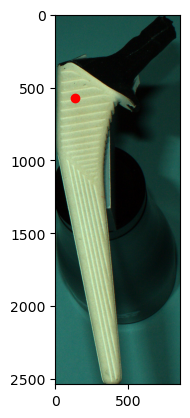

In [56]:
## may have to write own code to map vertex colors

import matplotlib.pyplot as plt
import operator

def get_color_from_uv_coord(uv, image, test=False):
    width, height = image.size

    pix_x, pix_y = uv[0] * width, (1 - uv[1]) * height
    pix_x = max(0, min(pix_x, width - 1))
    pix_y = max(0, min(pix_y, height - 1))

    if test:
        print(width, height)
        print(pix_x, pix_y)
        plt.imshow(image)
        plt.plot(pix_x, pix_y, 'ro')

    color = image.getpixel((pix_x, pix_y))
    return color

print(get_color_from_uv_coord((0.158511, 0.773667), Image.open(texture), test=True))

def create_vtk_from_obj(obj, texture_file, output):
    #get the vertices, colors, normals, and faces
    vertices, normals, colors, faces = parse_obj(obj, texture_file)

    #print(faces)

    #use these to create a vtk object

    # Create VTK objects
    poly_data = vtk.vtkPolyData()
    points = vtk.vtkPoints()
    vertex_colors = vtk.vtkUnsignedCharArray()
    vertex_normals = vtk.vtkFloatArray()
    triangles = vtk.vtkCellArray()

    # Set vertices
    for vertex in vertices:
        points.InsertNextPoint(vertex)
    poly_data.SetPoints(points)

    # Set vertex colors
    vertex_colors.SetNumberOfComponents(3)  # RGB values
    for color in colors:
        vertex_colors.InsertNextTuple3(*color)
    poly_data.GetPointData().SetScalars(vertex_colors)

    # Set vertex normals
    # vertex_normals.SetNumberOfComponents(3)  # XYZ values
    # for normal in normals:
    #     vertex_normals.InsertNextTuple3(*normal)
    # poly_data.GetPointData().SetNormals(vertex_normals)

    # Set faces
    for face in faces:
        triangle = vtk.vtkTriangle()
        triangle.GetPointIds().SetId(0, face[0])
        triangle.GetPointIds().SetId(1, face[1])
        triangle.GetPointIds().SetId(2, face[2])
        triangles.InsertNextCell(triangle)
    poly_data.SetPolys(triangles)

    # Write the VTK file
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(str(output))
    writer.SetInputData(poly_data)
    writer.Write()



def parse_obj(obj, texture_file):

    #open the texture image png/jpeg
    texture_image = Image.open(texture_file)

    #read in the obj file
    with open(obj, 'r') as file:
        vertices = []
        normals = []
        colors = []
        faces = []
        for line in file:
            line = line.strip()
            if line:
                values = line.split()
                category = values[0]
                if category == 'mtllib' or category == 'usemtl':
                    continue
                elif category == 'v':
                    coords = np.array(values[1:]).astype(float)
                    vertices.append(coords)
                elif category == 'vn':
                    coords = np.array(values[1:]).astype(float)
                    normals.append(coords)
                elif category == 'vt':
                    pix_coords = np.array(values[1:]).astype(float)
                    color = get_color_from_uv_coord(pix_coords, texture_image)
                    colors.append(color)
                elif category == 'f':
                    #parse these later
                    faces.append(values[1:])
            #break
        #print(faces)
    
    #now, turn each into a numpy array
    #vertices = np.stack(vertices)
    #normals = np.stack(normals)
    #colors = np.stack(colors)

    #get a list of the unique vertex information from the faces
        # we want to map each vertex to its correct normal and color values
    uniq = []
    vertex_unordered = []
    normal_unordered = []
    color_unordered = []
    coord_idxs = []
    u = 0
    for face in faces:
        for vertex in face:
            coord_idx, texture_idx, norm_idx = vertex.split('/')
            if coord_idx in uniq:
                continue
            uniq.append(coord_idx)
            cs_coord_idx = int(coord_idx)-1
            vertex_unordered.append((vertices[cs_coord_idx], cs_coord_idx))
            normal_unordered.append((normals[int(norm_idx)-1], cs_coord_idx))
            color_unordered.append((colors[int(texture_idx)-1], cs_coord_idx))
            #coord_idxs.append(int(coord_idx)-1)

    #have to order these by coord index
    vertex_ordered = [x[0] for x in sorted(vertex_unordered, key=lambda x: x[1])]
    normal_ordered = [x[0] for x in sorted(normal_unordered, key=lambda x: x[1])]
    color_ordered = [x[0] for x in sorted(color_unordered, key=lambda x: x[1])]

            #check to see the vertex color and position
            # if coord_idx == '2139':
            #     print("colors:", colors[int(texture_idx)-1])
            #     print("coords:", vertices[int(coord_idx)-1])
            

    #now, parse each of the faces
    final_faces = []
    for face in faces:
        final_face = []
        for vertex in face:
            coord_idx, texture_idx, norm_idx = vertex.split('/')
            #get the proper vertex
            final_face.append(int(coord_idx)-1)
        final_faces.append(final_face)

    #now that we have the vertices, faces, colors, and normals, turn this into a vtk file
    return vertex_ordered, normal_ordered, color_ordered, final_faces


create_vtk_from_obj(obj, texture, testdir/("test.vtk"))

In [ ]:
# """"""
# write down the steps of each part of the pipeline:

# 1.) If H1 Camera, convert the OBJ and PNG files to a vtk file
#       if NeRF, need to do something else
# 2.) Then, put this vtk file through the registration pipeline

# """"""

In [21]:
print(ICP_sol.RTs.s.numpy())

R = ICP_sol.RTs.R
t = ICP_sol.RTs.T
s = ICP_sol.RTs.s

[1.]


[[ 0.77793304  0.61680454  0.11988473]
 [ 0.17920054 -0.03491578 -0.98319279]
 [-0.6022519   0.78634156 -0.13769385]]
Transforms


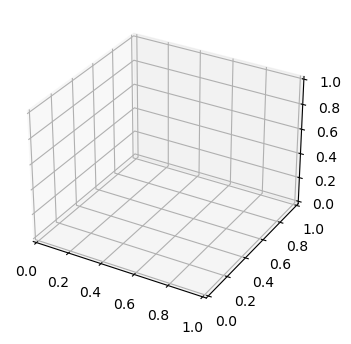

In [22]:
## Plot the fiducials

import importlib
import registration
from pathlib import Path
import matplotlib.pyplot as plt
importlib.reload(registration)


rootdir = Path('/home-local/kimm58/SPIE2023/data/H1Capture/hip5')
a = registration.get_fiducials_from_csv(rootdir.parent/("hip_5_centered_fiducials.csv"))

(pca_r, icp_r, icp_t) = registration.get_transforms(rootdir)

print(pca_r)
print("Transforms")
#print(pca_r, icp_r, icp_t)

a = registration.apply_transforms_to_fiducials(pca_r, icp_r, icp_t, a, debug=False)

#print(a)

t = registration.get_fiducials_from_csv(rootdir.parent/("static_centered_fiducials.csv"))

#print(t)
#print(t[:, 0])

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

#ax.scatter(x[:,0], x[:,1], x[:,2], marker='*', color='k', alpha=0.01)
# ax.scatter(t[:,0], t[:,1], t[:,2], marker='*', color='y')
# ax.scatter(a[:,0], a[:,1], a[:,2], marker='*', color='r')
# ax.set_xlim(-100, 100)
# ax.set_ylim(-100, 100)
# ax.set_zlim(-100, 100)
# ax.plot_trisurf(x[:,0], x[:,1], x[:,2], triangles=xf)
# ax.plot_trisurf(s[:,0], s[:,1], s[:,2], triangles=sf)

testout= rootdir/("registered_fiducials.vtk")
registration.create_vtk_pointcloud(a, testout)
testct = rootdir.parent/("CT_centered_fiducials.vtk")
registration.create_vtk_pointcloud(t, testct)

In [3]:
import numpy as np
np.dot(registration.get_fiducials_from_csv(rootdir.parent/("hip_1_centered_fiducials.csv")), pca_r.T)

array([[-41.40590074,  -4.98100308, -99.08060226],
       [ -8.86354543,   4.3259005 ,  76.16447649],
       [ 32.20881726,   0.27185711,  37.68544633]])

In [14]:
_,x,_,xf = registration.get_points_vtk(rootdir/("outputs")/("moving_ICP_aligned.vtk"))
_,s,_,sf = registration.get_points_vtk(rootdir/("outputs")/("static_centered.vtk"))
print(x[0])
x = np.stack(x)
s = np.stack(s)
print(x)

(11.340399742126465, -6.895480155944824, -10.440099716186523)
[[ 11.34039974  -6.89548016 -10.44009972]
 [ 12.36940002  -6.88741016 -10.73379993]
 [ 12.02270031  -6.93598986  -9.71049976]
 ...
 [ -9.12152004   2.29158998 -18.30850029]
 [-12.65950012   6.9577198  -22.69860077]
 [  6.0605998    9.08798981  61.93389893]]


In [25]:
import trimesh
#remove colors from the vertices
    #if green is higher than 200
def remove_colors_from_mesh(mesh, output):
    face_colors = mesh.visual.face_colors[:, :3]
    color_threshold = [0,200,0]
    faces_to_keep = np.any(face_colors <= color_threshold, axis=1)

    selectedv = mesh.vertices
    selectedf = mesh.faces[faces_to_keep]

    # Create a new mesh with the selected vertices and faces
    new_mesh = trimesh.Trimesh(vertices=selectedv, faces=selectedf)

    # Remove isolated vertices
    new_mesh.remove_unreferenced_vertices()

    new_mesh.export(output, file_type='ply')

p = trimesh.load_mesh('/home-local/kimm58/SPIE2023/data/NERF/test_green/wide/test.ply')
otest = Path('/home-local/kimm58/SPIE2023/data/NERF/test_green/wide/test_remove.ply')
remove_colors_from_mesh(p, otest)

In [26]:
p.visual.vertex_colors

TrackedArray([[144, 145, 146, 255],
              [142, 143, 143, 255],
              [143, 145, 145, 255],
              ...,
              [156, 130, 119, 255],
              [140,  98,  85, 255],
              [ 51,  24,  18, 255]], dtype=uint8)

In [31]:
from vtk.util.numpy_support import numpy_to_vtk

def convert_ply_to_vtk(input, output):
    # Load the PLY file using trimesh
    mesh = trimesh.load_mesh(str(input))

    # Extract the vertices and faces from the mesh
    vertices = mesh.vertices
    faces = mesh.faces.reshape(-1, 3)

    # Create a VTK PolyData object
    polydata = vtk.vtkPolyData()

    # Create a vtkPoints object and set the vertex coordinates
    vtk_points = vtk.vtkPoints()
    vtk_points.SetData(numpy_to_vtk(vertices))
    polydata.SetPoints(vtk_points)

    # Create a vtkCellArray to store the faces
    vtk_faces = vtk.vtkCellArray()

    # Add the faces to the vtkCellArray
    for face in faces:
        vtk_faces.InsertNextCell(3, [int(face[0]), int(face[1]), int(face[2])])

    polydata.SetPolys(vtk_faces)

    # Add color to the vertices
    colors = mesh.visual.vertex_colors  # Assuming color data exists in the PLY file

    vtk_colors = vtk.vtkUnsignedCharArray()
    vtk_colors.SetName("Colors")
    vtk_colors.SetNumberOfComponents(3)

    for color in colors:
        vtk_colors.InsertNextTuple3(int(color[0]), int(color[1]), int(color[2]))

    polydata.GetPointData().SetScalars(vtk_colors)

    # Write the PolyData to a VTK file
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(str(output))
    writer.SetInputData(polydata)
    writer.Write()

In [32]:
import vtk
from vtk.util.numpy_support import numpy_to_vtk

convert_ply_to_vtk('/home-local/kimm58/SPIE2023/data/NERF/test_green/wide/test.ply', '/home-local/kimm58/SPIE2023/data/NERF/test_green/wide/test.vtk')

In [57]:
import utils
importlib.reload(utils)

#p = trimesh.load_mesh('/home-local/kimm58/SPIE2023/data/NERF/test_green/wide/test.vtk')
p = Path('/home-local/kimm58/SPIE2023/data/NERF/test_green/wide/test.vtk')
otest = Path('/home-local/kimm58/SPIE2023/data/NERF/test_green/wide/test_remove.vtk')

utils.color_threshold_mesh(p, otest, abs_threshold=[150,200,150])

Creating mask based on color threshold of [150,200,150]...
Done creating mask. Now using mask to filter out vertices...
Total points: 7436376
Number of points to keep: 7221158
Now removing faces associated with removed vertices...
Done filtering faces. Now exporting vtk file...


In [67]:
#threshold based on bounding box (position)

importlib.reload(utils)

postest = '/home-local/kimm58/SPIE2023/data/NERF/test_green/wide/test_remove_pos.vtk'
utils.position_threshold_mesh(otest, postest)

Done creating mask. Now using mask to filter out vertices...
Total points: 7221158
Number of points to keep: 22755
Now removing faces associated with removed vertices...
Done filtering faces. Now exporting vtk file...


In [64]:
min = np.array([-0.4, -0.4, -0.4])
h = np.array([0, 0, 0])

print(np.any(h < min))

False
